## Deploy the Clip Interrogator on Amazon SageMaker

The [clip interrogator](https://github.com/pharmapsychotic/clip-interrogator) is a prompt engineering tool that combines [CLIP](https://openai.com/blog/clip/) and [BLIP](https://blog.salesforceairesearch.com/blip-bootstrapping-language-image-pretraining/) to optimize text prompts to match a given image. You can then use the resulting prompts with text-to-image models like [Stable Diffusion](https://huggingface.co/stabilityai/stable-diffusion-2-1) on Amazon SageMaker to create cool art!

In this notebook, we demonstrate how to use SageMaker [large model inference container](https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints-large-model-inference.html) to host the clip interrogator solution on Amazon SageMaker using DJLServing. DJLServing is a high-performance universal model serving solution powered by the Deep Java Library (DJL) that is programming language agnostic. To learn more about DJL and DJLServing, you can refer to the [blog post](https://aws.amazon.com/blogs/machine-learning/deploy-large-models-on-amazon-sagemaker-using-djlserving-and-deepspeed-model-parallel-inference/).

### Setup for Model Deployment
As a first step, we'll import the relevant libraries and configure several global variables such as the hosting image that will be used and the S3 location to store the relevant artifacts.

In [2]:
import sagemaker
import jinja2
from sagemaker import image_uris
import boto3
import os
import time
import json
from pathlib import Path
import json
import base64

In [3]:
role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
bucket = sess.default_bucket()  # bucket to house artifacts

In [4]:
model_bucket = sess.default_bucket()  # bucket to house artifacts
s3_code_prefix = "clip_interrogator"  # folder within bucket where code artifact will go
s3_model_prefix = "model_clip_interrogator"  # folder within bucket where code artifact will go
region = sess._region_name
account_id = sess.account_id()

s3_client = boto3.client("s3")
sm_client = boto3.client("sagemaker")
smr_client = boto3.client("sagemaker-runtime")

jinja_env = jinja2.Environment()

# define a variable to contain the s3url of the location that has the model
pretrained_model_location = f"s3://{model_bucket}/{s3_model_prefix}/"
print(f"Pretrained model will be uploaded to ---- > {pretrained_model_location}")

Pretrained model will be uploaded to ---- > s3://sagemaker-us-west-2-631450739534/model_clip_interrogator/


In [5]:
inference_image_uri = image_uris.retrieve(
    framework="djl-deepspeed", region=sess.boto_session.region_name, version="0.22.1"
)
inference_image_uri

'763104351884.dkr.ecr.us-west-2.amazonaws.com/djl-inference:0.22.1-deepspeed0.8.3-cu118'

### 1. Create SageMaker compatible model artifacts
In order to prepare our model for deployment to a SageMaker Endpoint for hosting, we will need to prepare a few things for SageMaker and our container. We will use a local folder as the location of these files including **serving.properties** that defines parameters for the LMI container and **requirements.txt** to detail what dependies to install.

In the **serving.properties** files define the the engine to use and model to host. Note the tensor_parallel_degree parameter which is set to a value of 1 in this scenario. In this example, we will use the `Salesforce/blip-image-captioning-large` and the `ViT-L-14/openai` models. Since both of the two models can fit on a sigle GPU we do not have to divide the model into multiple parts. In this case we will use a 'ml.g5.xlarge' instance which provides 1 GPU. Be careful not to specify a value larger than the instance provides or your deployment will fail. If you are choosing a bigger model and needs more GPU resources, please update the instance type and tensor parallel degree accordingly 

In [6]:
!mkdir -p clipinterrogator
!cp -r data clipinterrogator

In [7]:
%%writefile clipinterrogator/serving.properties
engine = Python
option.tensor_parallel_degree = 1
# option.s3url = {{s3url}}

Writing clipinterrogator/serving.properties


In [8]:
%%writefile clipinterrogator/requirements.txt
Pillow
requests
safetensors
tqdm
open_clip_torch
transformers>=4.27.1

Writing clipinterrogator/requirements.txt


### 2. Create a model.py with custom inference code
SageMaker allows you to bring your own script for inference. Here we create our **model.py** file with the appropriate code for the solution.

In [9]:
%%writefile clipinterrogator/model.py
import hashlib
import math
import numpy as np
import os,io
import requests
import time
import torch
import base64
import json

from dataclasses import dataclass
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM, BlipForConditionalGeneration, Blip2ForConditionalGeneration
from tqdm import tqdm
from typing import List, Optional
import open_clip


from djl_python import Input, Output

from safetensors.numpy import load_file, save_file

CAPTION_MODELS = {
    'blip-base': 'Salesforce/blip-image-captioning-base',   # 990MB
    'blip-large': 'Salesforce/blip-image-captioning-large', # 1.9GB
    'blip2-2.7b': 'Salesforce/blip2-opt-2.7b',              # 15.5GB
    'blip2-flan-t5-xl': 'Salesforce/blip2-flan-t5-xl',      # 15.77GB
    'git-large-coco': 'microsoft/git-large-coco',           # 1.58GB
}


CACHE_URL_BASE = 'https://huggingface.co/pharma/ci-preprocess/resolve/main/'


@dataclass 
class Config:
    # models can optionally be passed in directly
    caption_model = None
    caption_processor = None
    clip_model = None
    clip_preprocess = None

    # blip settings
    caption_max_length: int = 32
    caption_model_name: Optional[str] = 'blip-large' # use a key from CAPTION_MODELS or None
    caption_offload: bool = False

    # clip settings
    clip_model_name: str = 'ViT-L-14/openai'
    clip_model_path: Optional[str] = None
    clip_offload: bool = False

    # interrogator settings
    cache_path: str = '/opt/ml/cache'   # path to store cached text embeddings
    download_cache: bool = True # when true, cached embeds are downloaded from huggingface
    chunk_size: int = 2048      # batch size for CLIP, use smaller for lower VRAM
    data_path: str = os.path.join(os.path.dirname(__file__), 'data')
    device: str = ("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
    flavor_intermediate_count: int = 2048
    quiet: bool = False # when quiet progress bars are not shown

    # def apply_low_vram_defaults(self):
    #     self.caption_model_name = 'blip-base'
    #     self.caption_offload = True
    #     self.clip_offload = True
    #     self.chunk_size = 1024
    #     self.flavor_intermediate_count = 1024

class Interrogator():
    def __init__(self, config: Config):
        self.config = config
        self.device = config.device
        self.dtype = torch.float16 if self.device == 'cuda' else torch.float32
        self.caption_offloaded = True
        self.clip_offloaded = True
        self.load_caption_model()
        self.load_clip_model()

    def load_caption_model(self):
        if self.config.caption_model is None and self.config.caption_model_name:
            if not self.config.quiet:
                print(f"Loading caption model {self.config.caption_model_name}...")

            model_path = CAPTION_MODELS[self.config.caption_model_name]
            if self.config.caption_model_name.startswith('git-'):
                caption_model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype=torch.float32)
            elif self.config.caption_model_name.startswith('blip2-'):
                caption_model = Blip2ForConditionalGeneration.from_pretrained(model_path, torch_dtype=self.dtype)
            else:
                caption_model = BlipForConditionalGeneration.from_pretrained(model_path, torch_dtype=self.dtype)
            self.caption_processor = AutoProcessor.from_pretrained(model_path)

            caption_model.eval()
            if not self.config.caption_offload:
                caption_model = caption_model.to(self.config.device)
            self.caption_model = caption_model
        else:
            self.caption_model = self.config.caption_model
            self.caption_processor = self.config.caption_processor

    def load_clip_model(self):
        start_time = time.time()
        config = self.config

        clip_model_name, clip_model_pretrained_name = config.clip_model_name.split('/', 2)

        if config.clip_model is None:
            if not config.quiet:
                print(f"Loading CLIP model {config.clip_model_name}...")

            self.clip_model, _, self.clip_preprocess = open_clip.create_model_and_transforms(
                clip_model_name, 
                pretrained=clip_model_pretrained_name, 
                precision='fp16' if config.device == 'cuda' else 'fp32',
                device=config.device,
                jit=False,
                cache_dir=config.clip_model_path
            )
            self.clip_model.eval()
        else:
            self.clip_model = config.clip_model
            self.clip_preprocess = config.clip_preprocess
        self.tokenize = open_clip.get_tokenizer(clip_model_name)

        sites = ['Artstation', 'behance', 'cg society', 'cgsociety', 'deviantart', 'dribbble', 
                 'flickr', 'instagram', 'pexels', 'pinterest', 'pixabay', 'pixiv', 'polycount', 
                 'reddit', 'shutterstock', 'tumblr', 'unsplash', 'zbrush central']
        trending_list = [site for site in sites]
        trending_list.extend(["trending on "+site for site in sites])
        trending_list.extend(["featured on "+site for site in sites])
        trending_list.extend([site+" contest winner" for site in sites])

        raw_artists = load_list(config.data_path, 'artists.txt')
        artists = [f"by {a}" for a in raw_artists]
        artists.extend([f"inspired by {a}" for a in raw_artists])

        self._prepare_clip()
        self.artists = LabelTable(artists, "artists", self)
        self.flavors = LabelTable(load_list(config.data_path, 'flavors.txt'), "flavors", self)
        self.mediums = LabelTable(load_list(config.data_path, 'mediums.txt'), "mediums", self)
        self.movements = LabelTable(load_list(config.data_path, 'movements.txt'), "movements", self)
        self.trendings = LabelTable(trending_list, "trendings", self)
        self.negative = LabelTable(load_list(config.data_path, 'negative.txt'), "negative", self)

        end_time = time.time()
        if not config.quiet:
            print(f"Loaded CLIP model and data in {end_time-start_time:.2f} seconds.")

    def chain(
        self, 
        image_features: torch.Tensor, 
        phrases: List[str], 
        best_prompt: str="", 
        best_sim: float=0, 
        min_count: int=8,
        max_count: int=32, 
        desc="Chaining", 
        reverse: bool=False
    ) -> str:
        self._prepare_clip()

        phrases = set(phrases)
        if not best_prompt:
            best_prompt = self.rank_top(image_features, [f for f in phrases], reverse=reverse)
            best_sim = self.similarity(image_features, best_prompt)
            phrases.remove(best_prompt)
        curr_prompt, curr_sim = best_prompt, best_sim
        
        def check(addition: str, idx: int) -> bool:
            nonlocal best_prompt, best_sim, curr_prompt, curr_sim
            prompt = curr_prompt + ", " + addition
            sim = self.similarity(image_features, prompt)
            if reverse:
                sim = -sim
            
            if sim > best_sim:
                best_prompt, best_sim = prompt, sim
            if sim > curr_sim or idx < min_count:
                curr_prompt, curr_sim = prompt, sim
                return True
            return False

        for idx in tqdm(range(max_count), desc=desc, disable=self.config.quiet):
            best = self.rank_top(image_features, [f"{curr_prompt}, {f}" for f in phrases], reverse=reverse)
            flave = best[len(curr_prompt)+2:]
            if not check(flave, idx):
                break
            if _prompt_at_max_len(curr_prompt, self.tokenize):
                break
            phrases.remove(flave)

        return best_prompt

    def generate_caption(self, pil_image: Image) -> str:
        assert self.caption_model is not None, "No caption model loaded."
        self._prepare_caption()
        inputs = self.caption_processor(images=pil_image, return_tensors="pt").to(self.device)
        if not self.config.caption_model_name.startswith('git-'):
            inputs = inputs.to(self.dtype)
        tokens = self.caption_model.generate(**inputs, max_new_tokens=self.config.caption_max_length)
        return self.caption_processor.batch_decode(tokens, skip_special_tokens=True)[0].strip()

    def image_to_features(self, image: Image) -> torch.Tensor:
        self._prepare_clip()
        images = self.clip_preprocess(image).unsqueeze(0).to(self.device)
        with torch.no_grad(), torch.cuda.amp.autocast():
            image_features = self.clip_model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
        return image_features

    def interrogate_classic(self, image: Image, max_flavors: int=3, caption: Optional[str]=None) -> str:
        """Classic mode creates a prompt in a standard format first describing the image, 
        then listing the artist, trending, movement, and flavor text modifiers."""
        caption = caption or self.generate_caption(image)
        image_features = self.image_to_features(image)

        medium = self.mediums.rank(image_features, 1)[0]
        artist = self.artists.rank(image_features, 1)[0]
        trending = self.trendings.rank(image_features, 1)[0]
        movement = self.movements.rank(image_features, 1)[0]
        flaves = ", ".join(self.flavors.rank(image_features, max_flavors))

        if caption.startswith(medium):
            prompt = f"{caption} {artist}, {trending}, {movement}, {flaves}"
        else:
            prompt = f"{caption}, {medium} {artist}, {trending}, {movement}, {flaves}"

        return _truncate_to_fit(prompt, self.tokenize)

    def interrogate_fast(self, image: Image, max_flavors: int=32, caption: Optional[str]=None) -> str:
        """Fast mode simply adds the top ranked terms after a caption. It generally results in 
        better similarity between generated prompt and image than classic mode, but the prompts
        are less readable."""
        caption = caption or self.generate_caption(image)
        image_features = self.image_to_features(image)
        merged = _merge_tables([self.artists, self.flavors, self.mediums, self.movements, self.trendings], self)
        tops = merged.rank(image_features, max_flavors)
        return _truncate_to_fit(caption + ", " + ", ".join(tops), self.tokenize)

    def interrogate_negative(self, image: Image, max_flavors: int = 32) -> str:
        """Negative mode chains together the most dissimilar terms to the image. It can be used
        to help build a negative prompt to pair with the regular positive prompt and often 
        improve the results of generated images particularly with Stable Diffusion 2."""
        image_features = self.image_to_features(image)
        flaves = self.flavors.rank(image_features, self.config.flavor_intermediate_count, reverse=True)
        flaves = flaves + self.negative.labels
        return self.chain(image_features, flaves, max_count=max_flavors, reverse=True, desc="Negative chain")

    def interrogate(self, image, params, caption: Optional[str]=None) -> str:

        image = image
        params = params
        if "max_flavors" in params.keys():
            max_flavors = params.pop("max_flavors")
        else:
            max_flavors = 32
            
        if "min_flavors" in params.keys():
            min_flavors = params.pop("min_flavors")
        else:
            min_flavors = 8
        caption = caption or self.generate_caption(image)
        image_features = self.image_to_features(image)

        merged = _merge_tables([self.artists, self.flavors, self.mediums, self.movements, self.trendings], self)
        flaves = merged.rank(image_features, self.config.flavor_intermediate_count)
        best_prompt, best_sim = caption, self.similarity(image_features, caption)
        best_prompt = self.chain(image_features, flaves, best_prompt, best_sim, min_count=min_flavors, max_count=max_flavors, desc="Flavor chain")

        fast_prompt = self.interrogate_fast(image, max_flavors, caption=caption)
        classic_prompt = self.interrogate_classic(image, max_flavors, caption=caption)
        candidates = [caption, classic_prompt, fast_prompt, best_prompt]
        response = candidates[np.argmax(self.similarities(image_features, candidates))]
        return Output().add_as_json({"outputs": response})

    def rank_top(self, image_features: torch.Tensor, text_array: List[str], reverse: bool=False) -> str:
        self._prepare_clip()
        text_tokens = self.tokenize([text for text in text_array]).to(self.device)
        with torch.no_grad(), torch.cuda.amp.autocast():
            text_features = self.clip_model.encode_text(text_tokens)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            similarity = text_features @ image_features.T
            if reverse:
                similarity = -similarity
        return text_array[similarity.argmax().item()]

    def similarity(self, image_features: torch.Tensor, text: str) -> float:
        self._prepare_clip()
        text_tokens = self.tokenize([text]).to(self.device)
        with torch.no_grad(), torch.cuda.amp.autocast():
            text_features = self.clip_model.encode_text(text_tokens)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            similarity = text_features @ image_features.T
        return similarity[0][0].item()

    def similarities(self, image_features: torch.Tensor, text_array: List[str]) -> List[float]:
        self._prepare_clip()
        text_tokens = self.tokenize([text for text in text_array]).to(self.device)
        with torch.no_grad(), torch.cuda.amp.autocast():
            text_features = self.clip_model.encode_text(text_tokens)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            similarity = text_features @ image_features.T
        return similarity.T[0].tolist()

    def _prepare_caption(self):
        if self.config.clip_offload and not self.clip_offloaded:
            self.clip_model = self.clip_model.to('cpu')
            self.clip_offloaded = True
        if self.caption_offloaded:
            self.caption_model = self.caption_model.to(self.device)
            self.caption_offloaded = False

    def _prepare_clip(self):
        if self.config.caption_offload and not self.caption_offloaded:
            self.caption_model = self.caption_model.to('cpu')
            self.caption_offloaded = True
        if self.clip_offloaded:
            self.clip_model = self.clip_model.to(self.device)
            self.clip_offloaded = False


class LabelTable():
    def __init__(self, labels:List[str], desc:str, ci: Interrogator):
        clip_model, config = ci.clip_model, ci.config
        self.chunk_size = config.chunk_size
        self.config = config
        self.device = config.device
        self.embeds = []
        self.labels = labels
        self.tokenize = ci.tokenize

        hash = hashlib.sha256(",".join(labels).encode()).hexdigest()
        sanitized_name = self.config.clip_model_name.replace('/', '_').replace('@', '_')
        self._load_cached(desc, hash, sanitized_name)

        if len(self.labels) != len(self.embeds):
            self.embeds = []
            chunks = np.array_split(self.labels, max(1, len(self.labels)/config.chunk_size))
            for chunk in tqdm(chunks, desc=f"Preprocessing {desc}" if desc else None, disable=self.config.quiet):
                text_tokens = self.tokenize(chunk).to(self.device)
                with torch.no_grad(), torch.cuda.amp.autocast():
                    text_features = clip_model.encode_text(text_tokens)
                    text_features /= text_features.norm(dim=-1, keepdim=True)
                    text_features = text_features.half().cpu().numpy()
                for i in range(text_features.shape[0]):
                    self.embeds.append(text_features[i])

            if desc and self.config.cache_path:
                os.makedirs(self.config.cache_path, exist_ok=True)
                cache_filepath = os.path.join(self.config.cache_path, f"{sanitized_name}_{desc}.safetensors")
                tensors = {
                    "embeds": np.stack(self.embeds),
                    "hash": np.array([ord(c) for c in hash], dtype=np.int8)
                }
                save_file(tensors, cache_filepath)

        if self.device == 'cpu' or self.device == torch.device('cpu'):
            self.embeds = [e.astype(np.float32) for e in self.embeds]

    def _load_cached(self, desc:str, hash:str, sanitized_name:str) -> bool:
        if self.config.cache_path is None or desc is None:
            return False

        cached_safetensors = os.path.join(self.config.cache_path, f"{sanitized_name}_{desc}.safetensors")

        if self.config.download_cache and not os.path.exists(cached_safetensors):
            download_url = CACHE_URL_BASE + f"{sanitized_name}_{desc}.safetensors"
            try:
                os.makedirs(self.config.cache_path, exist_ok=True)
                _download_file(download_url, cached_safetensors, quiet=self.config.quiet)
            except Exception as e:
                print(f"Failed to download {download_url}")
                print(e)
                return False                

        if os.path.exists(cached_safetensors):
            try:
                tensors = load_file(cached_safetensors)
            except Exception as e:
                print(f"Failed to load {cached_safetensors}")
                print(e)
                return False
            if 'hash' in tensors and 'embeds' in tensors:
                if np.array_equal(tensors['hash'], np.array([ord(c) for c in hash], dtype=np.int8)):
                    self.embeds = tensors['embeds']
                    if len(self.embeds.shape) == 2:
                        self.embeds = [self.embeds[i] for i in range(self.embeds.shape[0])]
                    return True

        return False
    
    def _rank(self, image_features: torch.Tensor, text_embeds: torch.Tensor, top_count: int=1, reverse: bool=False) -> str:
        top_count = min(top_count, len(text_embeds))
        text_embeds = torch.stack([torch.from_numpy(t) for t in text_embeds]).to(self.device)
        with torch.cuda.amp.autocast():
            similarity = image_features @ text_embeds.T
            if reverse:
                similarity = -similarity
        _, top_labels = similarity.float().cpu().topk(top_count, dim=-1)
        return [top_labels[0][i].numpy() for i in range(top_count)]

    def rank(self, image_features: torch.Tensor, top_count: int=1, reverse: bool=False) -> List[str]:
        if len(self.labels) <= self.chunk_size:
            tops = self._rank(image_features, self.embeds, top_count=top_count, reverse=reverse)
            return [self.labels[i] for i in tops]

        num_chunks = int(math.ceil(len(self.labels)/self.chunk_size))
        keep_per_chunk = int(self.chunk_size / num_chunks)

        top_labels, top_embeds = [], []
        for chunk_idx in tqdm(range(num_chunks), disable=self.config.quiet):
            start = chunk_idx*self.chunk_size
            stop = min(start+self.chunk_size, len(self.embeds))
            tops = self._rank(image_features, self.embeds[start:stop], top_count=keep_per_chunk, reverse=reverse)
            top_labels.extend([self.labels[start+i] for i in tops])
            top_embeds.extend([self.embeds[start+i] for i in tops])

        tops = self._rank(image_features, top_embeds, top_count=top_count)
        return [top_labels[i] for i in tops]


def _download_file(url: str, filepath: str, chunk_size: int = 4*1024*1024, quiet: bool = False):
    r = requests.get(url, stream=True)
    if r.status_code != 200:
        return

    file_size = int(r.headers.get("Content-Length", 0))
    filename = url.split("/")[-1]
    progress = tqdm(total=file_size, unit="B", unit_scale=True, desc=filename, disable=quiet)
    with open(filepath, "wb") as f:
        for chunk in r.iter_content(chunk_size=chunk_size):
            if chunk:
                f.write(chunk)
                progress.update(len(chunk))
    progress.close()

def _merge_tables(tables: List[LabelTable], ci: Interrogator) -> LabelTable:
    m = LabelTable([], None, ci)
    for table in tables:
        m.labels.extend(table.labels)
        m.embeds.extend(table.embeds)
    return m

def _prompt_at_max_len(text: str, tokenize) -> bool:
    tokens = tokenize([text])
    return tokens[0][-1] != 0

def _truncate_to_fit(text: str, tokenize) -> str:
    parts = text.split(', ')
    new_text = parts[0]
    for part in parts[1:]:
        if _prompt_at_max_len(new_text + part, tokenize):
            break
        new_text += ', ' + part
    return new_text

def list_caption_models() -> List[str]:
    return list(CAPTION_MODELS.keys())

def list_clip_models() -> List[str]:
    return ['/'.join(x) for x in open_clip.list_pretrained()]

def load_list(data_path: str, filename: Optional[str] = None) -> List[str]:
    """Load a list of strings from a file."""
    if filename is not None:
        data_path = os.path.join(data_path, filename)
    with open(data_path, 'r', encoding='utf-8', errors='replace') as f:
        items = [line.strip() for line in f.readlines()]
    return items

with open('./model_name.json', 'rb') as openfile:
    json_object = json.load(openfile)
    
caption_model_name = json_object.pop('caption_model_name')
clip_model_name = json_object.pop('clip_model_name')
config = Config()
_service = Interrogator(config)

def handle(inputs: Input) -> Optional[Output]:

    if inputs.is_empty():
        return None
    data = inputs.get_as_json()

    img = data["inputs"]
    imgdata = base64.b64decode(img)
    image = Image.open(io.BytesIO(imgdata))

    params = data["parameters"]

    if "max_length" in params.keys():
        config.caption_max_length = params.pop("max_length")


    return _service.interrogate(image, params)

Writing clipinterrogator/model.py


In [10]:
model_names = {
    "caption_model_name":'blip-large', #@param ["blip-base", "blip-large", "git-large-coco"]
    "clip_model_name":'ViT-L-14/openai' #@param ["ViT-L-14/openai", "ViT-H-14/laion2b_s32b_b79k"]
}
with open("clipinterrogator/model_name.json",'w') as file:
    json.dump(model_names, file)

### 3. Create the Tarball and then upload to S3 location
Next, we will package our artifacts as `*.tar.gz` files for uploading to S3 for SageMaker to use for deployment.

In [11]:
%%sh
tar czvf model.tar.gz clipinterrogator/
rm -rf clipinterrogator

clipinterrogator/
clipinterrogator/model.py
clipinterrogator/requirements.txt
clipinterrogator/data/
clipinterrogator/data/artists.txt
clipinterrogator/data/movements.txt
clipinterrogator/data/mediums.txt
clipinterrogator/data/negative.txt
clipinterrogator/data/flavors.txt
clipinterrogator/model_name.json
clipinterrogator/serving.properties


In [12]:
s3_code_artifact = sess.upload_data("model.tar.gz", bucket, s3_code_prefix)
print(f"S3 Code or Model tar ball uploaded to --- > {s3_code_artifact}")

S3 Code or Model tar ball uploaded to --- > s3://sagemaker-us-west-2-631450739534/clip_interrogator/model.tar.gz


### 4. Create the SageMaker Model and SageMaker endpoint
Now that we have uploaded the model artifacts to S3, we can create a SageMaker endpoint using the high-level [python sdk](https://github.com/aws/sagemaker-python-sdk/tree/master/src/sagemaker).

In [13]:
from sagemaker.model import Model
from sagemaker.utils import name_from_base

model_name = name_from_base("clip-interrogator")
model = Model(
    image_uri=inference_image_uri,
    model_data=s3_code_artifact,
    role=role,
    name=model_name,
)

In [14]:

model.deploy(
    initial_instance_count=1,
    instance_type="ml.g5.xlarge",
    endpoint_name=model_name
)

---------------!

### Run Inference
Once the endpoint is deployed, we can invoke the endpoint to test the solution.

In [15]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

predictor = sagemaker.Predictor(
    endpoint_name=model_name,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer()
)

In [17]:
%%time
file_name="croissant.jpeg"  
with open(file_name, "rb") as f:
    payload = f.read()

payload = base64.b64encode(payload).decode()


result = predictor.predict(
                { 
                    "inputs" : payload, 
                    "parameters": { 
                        "max_length": 50,
                        "max_flavors": 32,
                    },
                }
)
text = result["outputs"]
result

CPU times: user 17.5 ms, sys: 212 µs, total: 17.7 ms
Wall time: 15.4 s


{'outputs': 'a close up of a plate with a croissant on it, pexels contest winner, wlop : :, anisotropic filtering, featured on artsation, interconnections, anime food, stylized border, picture of a loft in morning, foodphoto'}

### 5. Use prompt engineering to restyle image

We first deploy Stable Diffusion v2.1 endpoint to use it for inference. We use `model_id` = `"model-txt2img-stabilityai-stable-diffusion-v2-1-base"` to deploy endpoint from JumpStart

In [56]:
model_id = "model-txt2img-stabilityai-stable-diffusion-v2-1-base"

In [8]:
from sagemaker import image_uris, model_uris, script_uris, hyperparameters
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base


endpoint_name = name_from_base(f"jumpstart-example-{model_id}")

inference_instance_type = "ml.g5.2xlarge"

# Retrieve the inference docker container uri. This is the base HuggingFace container image for the default model above.
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope="inference",
    model_id=model_id,
    model_version=model_version,
    instance_type=inference_instance_type,
)

# Retrieve the model uri. This includes the pre-trained model and parameters as well as the inference scripts.
# This includes all dependencies and scripts for model loading, inference handling etc..
model_uri = model_uris.retrieve(
    model_id=model_id, model_version=model_version, model_scope="inference"
)

# To increase the maximum response size from the endpoint.
env = {
    "MMS_MAX_RESPONSE_SIZE": "20000000",
}

# Create the SageMaker model instance
model = Model(
    image_uri=deploy_image_uri,
    model_data=model_uri,
    role=role,
    predictor_cls=Predictor,
    name=endpoint_name,
    env=env,
)

# deploy the Model. Note that we need to pass Predictor class when we deploy model through Model class,
# for being able to run inference through the sagemaker API.
model_predictor = model.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    predictor_cls=Predictor,
    endpoint_name=endpoint_name,
)

----------!

We use the generated text as prompt input for our stable diffusion model, and the generated images looks similar to the original one.

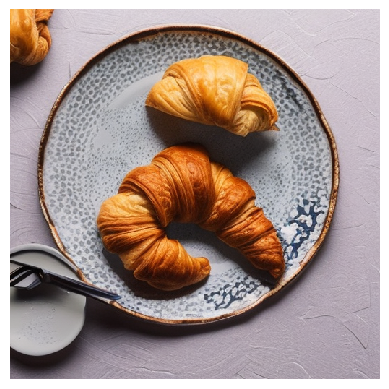

In [58]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import json

text = "a close up of a plate with a croissant on it, pexels contest winner, wlop : :, anisotropic filtering, featured on artsation, interconnections, anime food, stylized border, picture of a loft in morning, foodphoto"

body = {
  "guidance_scale": 6,
  "height": 512,
  "width": 512,
  "num_inference_steps": 100,
  "prompt": text,
  "num_images_per_prompt": 1,
  "seed": 337
}


model_predictor.content_type="application/json"
result = np.asarray(json.loads(model_predictor.predict(json.dumps(body).encode()).decode())["generated_images"])

# show_4x4_images(result)
plt.axis("off")
plt.imshow(result[0])

We then apply out own styles

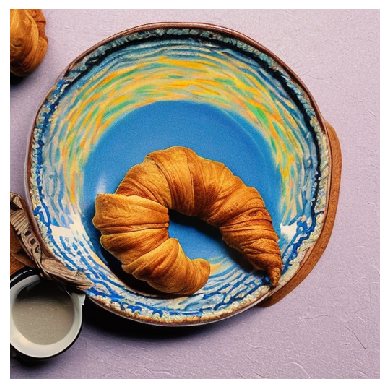

In [61]:
restyle_text = "This scene is a Van Gogh style painting, " + text
body["prompt"] = restyle_text

result = np.asarray(json.loads(model_predictor.predict(json.dumps(body).encode()).decode())["generated_images"])

plt.axis("off")
plt.imshow(result[0])

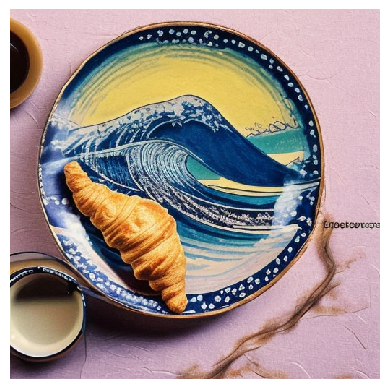

In [62]:
restyle_text = "This scene is a Nihonga painting with Hokusai style, " + text
body["prompt"] = restyle_text
result = np.asarray(json.loads(model_predictor.predict(json.dumps(body).encode()).decode())["generated_images"])

plt.axis("off")
plt.imshow(result[0])

## clean up

In [ ]:
predictor.delete_model()
predictor.delete_endpoint()
